# import

In [1]:


import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import pandas as pd
import ast
import os
import json
import seaborn as sns
import math
import statsmodels.api as sm
import pickle
import random

def normalize_times(times):
    min_time = min(times)
    max_time = max(times)
    time_range = max_time - min_time

    normalized_times = [(t - min_time) / time_range for t in times]
    return normalized_times


def determine_neuron_spike_pos(replay_motif_data,seq_type):
    neuron_spike_positions = {}
    for i in range(len(replay_motif_data)):

        if replay_motif_data.cluster_seq_type[i] == seq_type:

            replay_neurons = ast.literal_eval(replay_motif_data.cluster_neurons[i])
            replay_spikes = np.array(ast.literal_eval(replay_motif_data.cluster_spike_times[i]))

            norm_replay_spikes = normalize_times(replay_spikes)

            replay_neurons_fspike_only = replace_repeats_with_string(replay_neurons)

            for index,neur_id in enumerate(replay_neurons_fspike_only):
                if not neur_id == 'repeat':
                    if neur_id in neuron_spike_positions:
                        neuron_spike_positions[neur_id] += [norm_replay_spikes[index]]

                    else:
                        neuron_spike_positions[neur_id] = [norm_replay_spikes[index]]
    return neuron_spike_positions

def replace_repeats_with_string(numbers):
    seen = set()
    result = []

    for num in numbers:
        if num in seen:
            result.append('repeat')
        else:
            result.append(num)
            seen.add(num)

    return result


def load_input_params(pp_path, file, mouse_session_recording):
    input_params_path = os.path.join(pp_path, file, 'trainingData', f'params_{mouse_session_recording}.json')
    input_config = load_json(input_params_path)
    behav_time_interval_start = input_config['time_span'][0]
    print(f"      A corresponding time span has been found. Time span set to {behav_time_interval_start}")
    return behav_time_interval_start

def load_behav_data(dat_path, behav_time_interval_start):
    print("\nLOADING BEHAV DATA")
    behav_sync = pd.read_csv(os.path.join(dat_path, 'behav_sync', '2_task', 'Behav_Ephys_Camera_Sync.csv'))
    transitions = pd.read_csv(os.path.join(dat_path, 'behav_sync', '2_task', 'Transition_data_sync.csv'))

    behav_mask = (behav_sync.PokeIN_EphysTime > behav_time_interval_start[0]) & (behav_sync.PokeIN_EphysTime < behav_time_interval_start[1])
    poke_in_times = behav_sync[behav_mask].PokeIN_EphysTime - behav_time_interval_start[0]
    ports = behav_sync[behav_mask].Port
    print('done')
    return behav_sync, transitions, poke_in_times, ports,behav_mask

# ## set ppseq file
def find_example_file(PP_PATH, example = '178_1_7'):
    for file_ in os.listdir(PP_PATH):
        if example in file_:
            file = file_
    return file 

def Load_example_data(pp_path, file, dat_path, mouse_session_recording = '178_1_7'):
    # Load processed spike data
    latent_event_history_df_split, spikes_seq_type_adjusted, neuron_order, ordered_preferred_type, neuron_index, config = load_processed_spike_data(pp_path, file)
    
    
    # Load the timespan used for pppseq
    behav_time_interval_start = load_input_params(pp_path, file, mouse_session_recording)
    
    # Load behaviour data
    behav_sync, transitions, poke_in_times, ports,behav_mask = load_behav_data(dat_path, behav_time_interval_start)
    
    
    neuron_response_df = pd.read_csv(pp_path + file + r"\neuron_response.csv")
    bkgd_log_proportions_array = pd.read_csv(pp_path + file + r"\bkgd_log_proportions_array.csv")

    # Return all loaded data for further processing if needed
    return {
        "latent_event_history_df_split": latent_event_history_df_split,
        "spikes_seq_type_adjusted": spikes_seq_type_adjusted,
        "neuron_order": neuron_order,
        "ordered_preferred_type": ordered_preferred_type,
        "neuron_index": neuron_index,
        "config": config,
        "behav_sync": behav_sync,
        "transitions": transitions,
        "poke_in_times": poke_in_times,
        "ports": ports,
        "neuron_response_df" : neuron_response_df,
        "bkgd_log_proportions_array" : bkgd_log_proportions_array,
        "behav_time_interval_start" : behav_time_interval_start,
        "behav_mask" : behav_mask
    }
    
def plot_zoomed_example_raster(data,ordering,colors,timeframe):

    mask = (data["spikes_seq_type_adjusted"].timestamp>timeframe[0])*(data["spikes_seq_type_adjusted"].timestamp<timeframe[-1])

    ## neuron order:

    #define neuron order
    neuron_index,ordered_preferred_type = sortperm_neurons(data["bkgd_log_proportions_array"],data["config"],data["neuron_response_df"], sequence_ordering=ordering)
    # make a list of idndies for each neurons new position
    neuron_permute_loc = np.zeros(len(neuron_index))
    for i in range(len(neuron_index)):
        neuron_permute_loc[i] = int(list(neuron_index).index(i))

    neuron_permute_loc = np.array(shuffle(list(neuron_permute_loc.astype(int))))
    neuron_order = neuron_permute_loc[data["spikes_seq_type_adjusted"].neuron.values.astype(int)-1]

    # make a list of idndies for each neurons new position
    neuron_permute_loc = np.zeros(len(neuron_index))
    for i in range(len(neuron_index)):
        neuron_permute_loc[i] = int(list(neuron_index).index(i))
    #         neuron_order = neuron_permute_loc[unmasked_spikes_df.neuron-1]
    neuron_order = neuron_permute_loc[ data["spikes_seq_type_adjusted"].neuron.values.astype(int)-1]

    ## plotting:
    nrow = 1
    ncol = 1

    fig, ax = plt.subplots(nrow, ncol,figsize=(4, 5))

    # plot background in grey 
    background_keep_mask =  data["spikes_seq_type_adjusted"][mask].sequence_type_adjusted <= 0
    ax.scatter( data["spikes_seq_type_adjusted"][mask][background_keep_mask].timestamp, neuron_order[mask][background_keep_mask],marker = 'o', s=20, linewidth=0,color = 'grey' ,alpha=0.3)

    # plot spikes without background
    background_remove_mask = data["spikes_seq_type_adjusted"][mask].sequence_type_adjusted >= 0
    c_ = np.array(colors)[data["spikes_seq_type_adjusted"][mask][background_remove_mask].sequence_type_adjusted.values.astype(int)]
    # ## faster:
    ax.scatter( data["spikes_seq_type_adjusted"][mask][background_remove_mask].timestamp, neuron_order[mask][background_remove_mask],marker = 'o', s=20, linewidth=0,color = c_ ,alpha=1)

    return

def load_processed_spike_data(pp_path, file):
    print("\nLOADING processed_spike_data")
    analysis_path = os.path.join(pp_path, file, "analysis_output")
    
    latent_event_history_df_split = load_pickle(os.path.join(analysis_path, "latent_event_history_df_split.pickle"))
    spikes_seq_type_adjusted = load_pickle(os.path.join(analysis_path, "spikes_seq_type_adjusted.pickle"))
    neuron_order = np.load(os.path.join(analysis_path, 'neuron_order.npy'))
    ordered_preferred_type = np.load(os.path.join(analysis_path, 'ordered_preferred_type.npy'))
    neuron_index = np.load(os.path.join(analysis_path, 'neuron_index.npy'))

    config = eval(load_json(os.path.join(pp_path, file, 'config_file.json')))

    return latent_event_history_df_split, spikes_seq_type_adjusted, neuron_order, ordered_preferred_type, neuron_index, config


def shuffle(aList):
    random.shuffle(aList)
    return aList

def load_pickle(file_path):
    with open(file_path, "rb") as input_file:
        return pickle.load(input_file)


def load_json(file_path):
    with open(file_path) as f:
        return json.load(f)
    

def sortperm_neurons(bkgd_log_proportions_array,config,neuron_response_df, sequence_ordering=None, th=0.2):
    ## this is number of neurons in total
    N_neurons= bkgd_log_proportions_array.shape[1]
    ## number of sequences from json file 
    n_sequences = config["num_sequence_types"]
    # the 18 neuron params for each neuron from the last iteration
    all_final_globals = neuron_response_df.iloc[-N_neurons:]
    # this cuts it down to just the first 6 params - i think this correspond sto the first param for each seq type? response probABILITY - ie the chance that a neuron spikes in a given latent seq 
    resp_prop = np.exp(all_final_globals.values[:, :n_sequences])#
    # this takes the next 6 params - which i think are the offset values
    offset = all_final_globals.values[-N_neurons:, n_sequences:2*n_sequences]
    ## finds the max response value - ie. which seq it fits to? 
    peak_response = np.amax(resp_prop, axis=1)
    # then threshold the reponse
    has_response = peak_response > np.quantile(peak_response, th)
    # I thin this is the sequence that the neuron has the max response for: ie. we are ordering them by max response 
    preferred_type = np.argmax(resp_prop, axis=1)
    if sequence_ordering is None:
        # order them by max reponse 
        ordered_preferred_type = preferred_type
    else:
        #order them differnetly 
        ordered_preferred_type = np.zeros(N_neurons)#
        # loop through each sequence
        for seq in range(n_sequences):
            # where does  max repsone = user defined seque
            seq_indices = np.where(preferred_type == sequence_ordering[seq])
            # change order to different seq
            ordered_preferred_type[seq_indices] = seq

    # reorder the offset params according to max respsone
    preferred_delay = offset[np.arange(N_neurons), preferred_type]
    Z = np.stack([has_response, ordered_preferred_type+1, preferred_delay], axis=1)
    indexes = np.lexsort((Z[:, 2], Z[:, 1], Z[:, 0]))
    return indexes,ordered_preferred_type




In [2]:

# from Utilities.utils import *

# Get the current working directory
current_working_dir = os.getcwd()
current_working_dir = '//'.join(current_working_dir.split('\\')[0:-1]) + r'//data/f3//'

yellow = '#8FC681'
green = '#4DA5BF'
blue = '#FFD161'
red = '#36495E'
dark_blue = '#724F94'
purple = '#EE7060'
gold = '#C6963E'
colors = ['---',red,green,yellow,blue,purple,gold,dark_blue]


sleep_time_point_df = pd.read_csv(current_working_dir + 'sleep_time_points.csv')
expert_mice = sleep_time_point_df[sleep_time_point_df.group == 'expert'].mir.values

# figure B


LOADING processed_spike_data
      A corresponding time span has been found. Time span set to [5400, 6000]

LOADING BEHAV DATA
done
[np.int64(1), np.int64(4), np.int64(3), np.int64(0), np.int64(5), np.int64(2)]


C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_49772\494885184.py:179: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  return pickle.load(input_file)


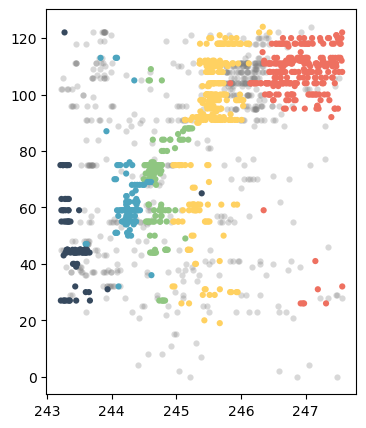

In [3]:
# Get the current working directory
f3_working_dir = os.getcwd()
f3_working_dir = '//'.join(f3_working_dir.split('\\')[0:-1]) + r'//data/f2//'

PP_PATH = f3_working_dir + 'ppseq_output_awake\\'
dat_path = f3_working_dir + 'example_mouse_data\\'
        
file = find_example_file(PP_PATH)
        
                    
data = Load_example_data(PP_PATH, file, dat_path)

### change the color ordering to standard color ordering: 
# recolor and save these plots out
current_color_order = [purple, blue, red, gold, yellow, green]
colors = ['---',red,green,yellow,blue,purple,gold,dark_blue]
# ## recolor based on current and desired color order
new_order_inds = [0]
for item in current_color_order:
    new_order_inds += [np.where(np.array(colors) == item)[0][0]]
# apply this ordering
new_colors = colors.copy()
for i,index in enumerate(new_order_inds):
    colors[index] = new_colors[i]                          
# determine new ordering based on this as well
ordering = list((np.array(new_order_inds)-1)[np.array(new_order_inds)-1 >=0])
#swap last 'extra' seq down to the bottom 
ordering = [ordering[-1]] + ordering[0:-1]
print(ordering)

# plot zoomed example
plot_zoomed_example_raster(data,ordering,colors,timeframe = [243.2,247.57])

# figure C

Text(0.5, 1.0, 'held sequences in colour and extra sequences + background in grey')

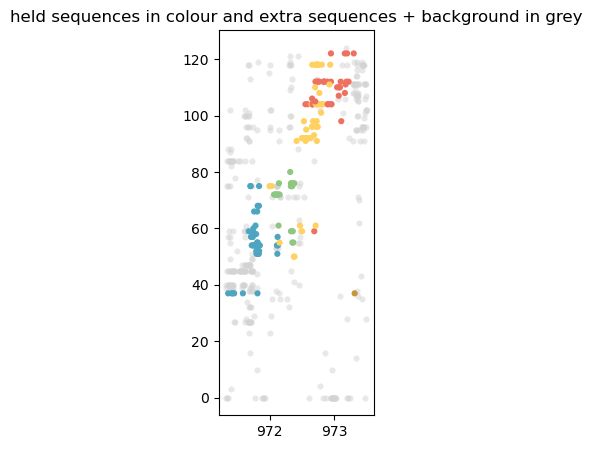

In [4]:
file_path = current_working_dir + 'example_replay_data.json'
with open(file_path, 'r') as file:
    example_sleep_data = json.load(file)

# example_sleep_spikes 
spikes_df = pd.read_csv(current_working_dir + 'example_replay_spikes.csv')

# caluclate interval timings and end points
interval_lengths =[]
for interval in example_sleep_data['behav_time_interval_start']:
    interval_lengths+= [np.diff(interval)[0]]
total_time = sum(interval_lengths)
interval_end_points = np.cumsum(interval_lengths)

# 10
timeframe = [971.3,973.5]

mask = (spikes_df.timestamp>timeframe[0])*(spikes_df.timestamp<timeframe[-1])
## neuron order:

#define neuron order
neuron_permute_loc = np.zeros(len(example_sleep_data["neuron_index"]))
for i in range(len(example_sleep_data["neuron_index"])):
    neuron_permute_loc[i] = int(list(example_sleep_data["neuron_index"]).index(i))
neuron_order = neuron_permute_loc[(spikes_df.neuron-1).astype(int)]

## plotting:

fig, ax = plt.subplots(1, 1,figsize=(2, 5))

# plot background in grey 
background_keep_mask = []
for item in spikes_df[mask].sequence_type_adjusted:
    if item < 0 or item >= 7.0:
        background_keep_mask.append(True)
    else:
        background_keep_mask.append(False)
background_keep_mask = np.array(background_keep_mask)
ax.scatter(spikes_df[mask][background_keep_mask].timestamp, neuron_order[mask][background_keep_mask],marker = 'o', s=20, linewidth=0,color = 'lightgrey' ,alpha=0.5)

# plot spikes without background
background_remove_mask = spikes_df[mask].sequence_type_adjusted >= 0
background_remove_mask = (spikes_df[mask].sequence_type_adjusted >= 0)*(spikes_df[mask].sequence_type_adjusted != 7.0)*(spikes_df[mask].sequence_type_adjusted != 8.0)
c_ = np.array(colors)[spikes_df[mask][background_remove_mask].sequence_type_adjusted.values.astype(int)]
# ## faster:
ax.scatter(spikes_df[mask][background_remove_mask].timestamp, neuron_order[mask][background_remove_mask],marker = 'o', s=20, linewidth=0,color = c_ ,alpha=1)
ax.set_title('held sequences in colour and extra sequences + background in grey')

# figure D

C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_49772\2078301624.py:26: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  std_devs.append(scipy.stats.sem(neuron_spike_positions[neuron]))


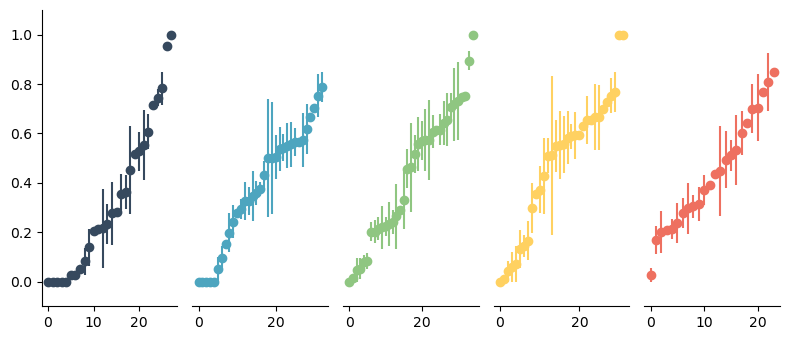

In [6]:
replay_motif_data= pd.read_csv('Z:\\projects\\sequence_squad\\organised_data\\ppseq_data\\finalised_output\\striatum\\paper_submission\\post_sleep\\\\178_1_7_run_1207023_1350\\\\_final_analysis_output\\chunk3_13300to14300\\temporal_structure_analysis\\replay_motif_data_updated.csv')


# filter for sequentially forward replay
sequential_replay_motif_data = replay_motif_data[replay_motif_data.catagory == 'forward']
sequential_replay_motif_data = sequential_replay_motif_data.reset_index(drop = True)

forward_neuron_spike_positions_all_seqs = []
for i in range(1,7):
    forward_neuron_spike_positions_all_seqs += [determine_neuron_spike_pos(sequential_replay_motif_data,i)]

fig, axs = plt.subplots(1,5, figsize=(8,3.5))
ordering = [4,3,0,5,2]

for i, ax in enumerate(axs):
    idx = ordering[i]
    neuron_spike_positions = forward_neuron_spike_positions_all_seqs[idx]

    if len(neuron_spike_positions) > 1:
        means = []
        std_devs = []
        neurs = []
        for neuron in neuron_spike_positions:
            neurs.append(neuron)
            means.append(np.mean(neuron_spike_positions[neuron]))
            std_devs.append(scipy.stats.sem(neuron_spike_positions[neuron]))

        # sort
        sorted_data = sorted(zip(means, std_devs))
        sorted_means, sorted_std_devs = zip(*sorted_data)

        ax.errorbar(range(len(means)), sorted_means, yerr=sorted_std_devs,
                    fmt='o', capsize=0, color=colors[idx+1])

    ax.set_ylim(-0.1, 1.1)

    # ---- REMOVE TOP + RIGHT SPINES ----
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # ---- REMOVE ALL Y–TICKS EXCEPT LEFTMOST ----
    if i != 0:
        ax.set_yticks([])
        ax.spines['left'].set_visible(False)   # remove left line
    else:
        ax.spines['left'].set_visible(True)    # keep left axis on first subplot
        ax.yaxis.set_tick_params(width=0.8)


fig.tight_layout()


# figure E

# figure F

Text(0.5, 1.0, 'held sequences in colour and extra sequences + background in grey')

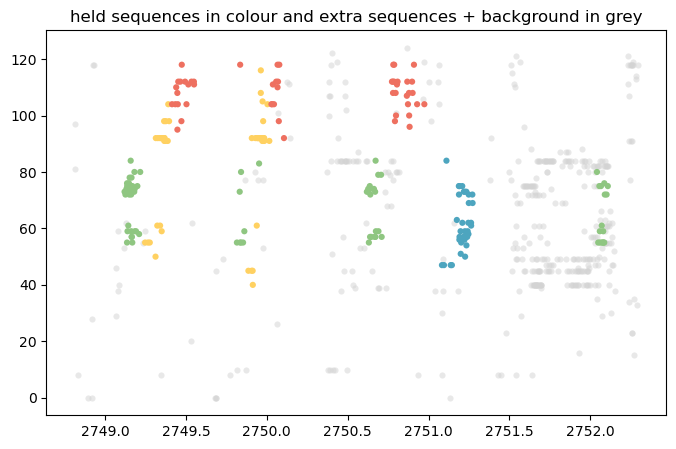

In [ ]:
file_path = current_working_dir + 'example_replay_data.json'
with open(file_path, 'r') as file:
    example_sleep_data = json.load(file)

# example_sleep_spikes 
spikes_df = pd.read_csv(current_working_dir + 'example_replay_spikes.csv')

# caluclate interval timings and end points
interval_lengths =[]
for interval in example_sleep_data['behav_time_interval_start']:
    interval_lengths+= [np.diff(interval)[0]]
total_time = sum(interval_lengths)
interval_end_points = np.cumsum(interval_lengths)

timeframe = [2748.8,2752.3]

mask = (spikes_df.timestamp>timeframe[0])*(spikes_df.timestamp<timeframe[-1])
## neuron order:

#define neuron order
neuron_permute_loc = np.zeros(len(example_sleep_data["neuron_index"]))
for i in range(len(example_sleep_data["neuron_index"])):
    neuron_permute_loc[i] = int(list(example_sleep_data["neuron_index"]).index(i))
neuron_order = neuron_permute_loc[(spikes_df.neuron-1).astype(int)]


## plotting:

fig, ax = plt.subplots(1, 1,figsize=(8, 5))


# plot background in grey 
background_keep_mask = []
for item in spikes_df[mask].sequence_type_adjusted:
    if item < 0 or item >= 7.0:
        background_keep_mask.append(True)
    else:
        background_keep_mask.append(False)
background_keep_mask = np.array(background_keep_mask)
ax.scatter(spikes_df[mask][background_keep_mask].timestamp, neuron_order[mask][background_keep_mask],marker = 'o', s=20, linewidth=0,color = 'lightgrey' ,alpha=0.5)

# plot spikes without background
background_remove_mask = spikes_df[mask].sequence_type_adjusted >= 0
background_remove_mask = (spikes_df[mask].sequence_type_adjusted >= 0)*(spikes_df[mask].sequence_type_adjusted != 7.0)*(spikes_df[mask].sequence_type_adjusted != 8.0)
c_ = np.array(colors)[spikes_df[mask][background_remove_mask].sequence_type_adjusted.values.astype(int)]
# ## faster:
ax.scatter(spikes_df[mask][background_remove_mask].timestamp, neuron_order[mask][background_remove_mask],marker = 'o', s=20, linewidth=0,color = c_ ,alpha=1)
ax.set_title('held sequences in colour and extra sequences + background in grey')

# figure G

# figure H

# figure I

# figure J

# figure K

# figure L

# figure M

# figure N

# figure O